In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("rayhanzamzamy/non-and-biodegradable-waste-dataset")
print("Path to dataset files:", path)


100%|██████████| 1.86G/1.86G [00:18<00:00, 110MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rayhanzamzamy/non-and-biodegradable-waste-dataset/versions/2


In [3]:
class WasteDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = []
        self.labels = []

        for label in ["B", "N"]:  # B for Biodegradable, N for Non-Biodegradable
            subfolder = os.path.join(folder, label)
            for img_file in os.listdir(subfolder):
                self.images.append(os.path.join(subfolder, img_file))
                self.labels.append(0 if label == "B" else 1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label


In [4]:
transform = transforms.Compose([
    transforms.Resize((60, 60)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create training and test datasets
train_folders = [os.path.join(path, "TRAIN.1"), os.path.join(path, "TRAIN.2"),
                 os.path.join(path, "TRAIN.3"), os.path.join(path, "TRAIN.4")]
test_folder = os.path.join(path, "TEST")

# Load datasets
train_datasets = [WasteDataset(folder, transform=transform) for folder in train_folders]
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
test_dataset = WasteDataset(test_folder, transform=transform)

# Split training set for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
class WasteClassifier(nn.Module):
    def __init__(self):
        super(WasteClassifier, self).__init__()
        # Load pretrained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True)

        # Freeze the first few layers
        for param in list(self.vgg16.features.parameters())[:15]:
            param.requires_grad = False

        # Modify the classifier layers
        self.vgg16.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the output of the feature layer
            nn.Linear(512 * 1 * 1 * 7 * 7, 256),  # Adjust the input to match output of VGG16
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.vgg16(x)
        return x


# Initialize model, loss function, and optimizer
model = WasteClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [8]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


Epoch [1/10], Train Loss: 0.1034, Val Loss: 0.0957
Epoch [2/10], Train Loss: 0.0623, Val Loss: 0.0764
Epoch [3/10], Train Loss: 0.0391, Val Loss: 0.1021
Epoch [4/10], Train Loss: 0.0283, Val Loss: 0.2524
Epoch [5/10], Train Loss: 0.0192, Val Loss: 0.2539
Epoch [6/10], Train Loss: 0.0175, Val Loss: 0.2029
Epoch [7/10], Train Loss: 0.0164, Val Loss: 0.2307
Epoch [8/10], Train Loss: 0.0133, Val Loss: 0.3131
Epoch [9/10], Train Loss: 0.0138, Val Loss: 0.2996
Epoch [10/10], Train Loss: 0.0113, Val Loss: 0.2832


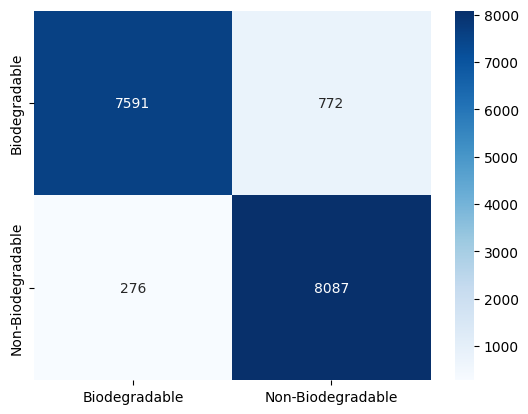

                   precision    recall  f1-score   support

    Biodegradable       0.96      0.91      0.94      8363
Non-Biodegradable       0.91      0.97      0.94      8363

         accuracy                           0.94     16726
        macro avg       0.94      0.94      0.94     16726
     weighted avg       0.94      0.94      0.94     16726



In [9]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).int()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Biodegradable", "Non-Biodegradable"], yticklabels=["Biodegradable", "Non-Biodegradable"])
plt.show()
print(classification_report(y_true, y_pred, target_names=["Biodegradable", "Non-Biodegradable"]))


In [16]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
torch.save(model.state_dict(), "waste_classifier.pth")



#model = WasteClassifier()  # Initialize the model
#model.load_state_dict(torch.load('waste_classifier_state_dict.pth'))
#model.eval()  # Set to evaluation mode


In [22]:
torch.save(model.state_dict(), '/content/drive/My Drive/DP/waste_classifier_state_dict.pth')


In [14]:
torch.save(model, 'waste_classifier_model.pth')



#model = torch.load('waste_classifier_model.pth')
#model.eval()  # Set to evaluation mode

In [21]:
torch.save(model, '/content/drive/My Drive/DP/waste_classifier.pth')


In [15]:
def predict_waste_type(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        pred_prob = output.item()
        label = "Biodegradable" if pred_prob < 0.5 else "Non-Biodegradable"
    print(f"Prediction: {label} (Probability: {pred_prob:.2f})")

# Example usage
# predict_waste_type("/path/to/image.jpg")
